# Medical Provider Fraud Detection Analysis

In [1]:
# import libraries 
!pip install xgboost

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn import decomposition, datasets
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
    

  Using cached xgboost-1.7.5-py3-none-manylinux2014_x86_64.whl (200.3 MB)


In [2]:
newpath = r'figures' 
if not os.path.exists(newpath):
    os.makedirs(newpath)
    
# change preferences here
# set save_figs = False to create figures without saving them
save_figs = True

In [3]:
# read datasets 
df_out = pd.read_csv('data/Outpatientdata.csv')
df_in = pd.read_csv('data/Inpatientdata.csv')
df_ben = pd.read_csv('data/Beneficiarydata.csv')
df_label = pd.read_csv('data/Labels.csv')

df_out = df_out.merge(df_ben, on='BeneID', how='inner')
df_out = df_out.merge(df_label, on='Provider', how='inner')

df_in = df_in.merge(df_ben, on='BeneID', how='inner')
df_in = df_in.merge(df_label, on='Provider', how='inner')

# convert output label to binary 
df_out['Label'] = np.where(df_out['PotentialFraud'] == 'Yes', 1, 0)
df_out.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud,Label
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,2,2,2,2,0,0,30,50,Yes,1
1,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,1,1,1,2,0,0,1810,760,Yes,1
2,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,...,1,1,1,2,0,0,1810,760,Yes,1
3,BENE11004,CLM173224,2009-02-03,2009-02-03,PRV56011,20,PHY339887,NaN,NaN,20381,...,1,1,1,2,0,0,1810,760,Yes,1
4,BENE11004,CLM224741,2009-03-03,2009-03-03,PRV56011,40,PHY345721,NaN,NaN,V6546,...,1,1,1,2,0,0,1810,760,Yes,1


In [4]:
df_out.shape

(517737, 53)

In [5]:
# examine potential fraud rows 
df_in['Label'] = np.where(df_in['PotentialFraud'] == 'Yes', 1, 0)
df_in.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud,Label
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,1,2,1,1,36000,3204,60,70,Yes,1
1,BENE17521,CLM34721,2009-01-20,2009-02-01,PRV55912,19000,PHY349293,PHY370861,PHY363291,2009-01-20,...,1,2,2,2,19000,1068,100,20,Yes,1
2,BENE21718,CLM72336,2009-10-17,2009-11-04,PRV55912,17000,PHY334706,PHY334706,NaN,2009-10-17,...,1,1,2,2,17000,1068,1050,540,Yes,1
3,BENE22934,CLM73394,2009-10-25,2009-10-29,PRV55912,13000,PHY390614,PHY323689,PHY363291,2009-10-25,...,1,1,1,2,27000,2136,450,160,Yes,1
4,BENE24402,CLM32911,2009-01-08,2009-01-12,PRV55912,3000,PHY380413,PHY432598,NaN,2009-01-08,...,1,2,2,2,3000,1068,8900,740,Yes,1


In [6]:
# encode indicator for outpatient and join datasets
df_out['Outpatient'] = 1
df_in['Outpatient'] = 0
df_full = df_out.append(df_in)
df_full.head()

/tmp/ipykernel_318/2375257133.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_full = df_out.append(df_in)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud,Label,Outpatient,AdmissionDt,DischargeDt,DiagnosisGroupCode
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,0,0,30,50,Yes,1,1,NaN,NaN,NaN
1,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,0,0,1810,760,Yes,1,1,NaN,NaN,NaN
2,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,...,0,0,1810,760,Yes,1,1,NaN,NaN,NaN
3,BENE11004,CLM173224,2009-02-03,2009-02-03,PRV56011,20,PHY339887,NaN,NaN,20381,...,0,0,1810,760,Yes,1,1,NaN,NaN,NaN
4,BENE11004,CLM224741,2009-03-03,2009-03-03,PRV56011,40,PHY345721,NaN,NaN,V6546,...,0,0,1810,760,Yes,1,1,NaN,NaN,NaN


# EDA

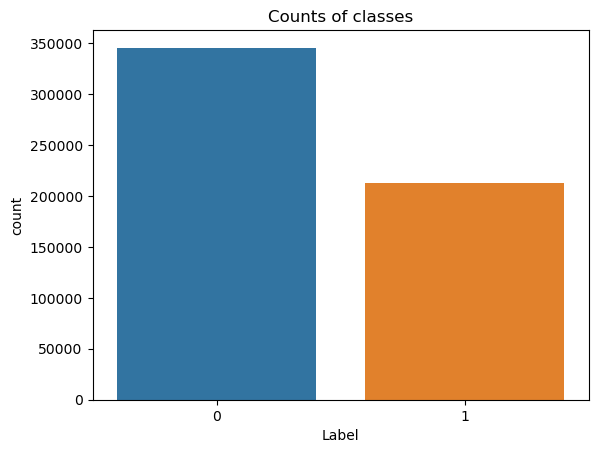

In [7]:
# plot counts of label classes
sns.countplot(data=df_full, x='Label');
plt.title('Counts of classes');

if save_figs:
    plt.savefig('figures/class_counts');

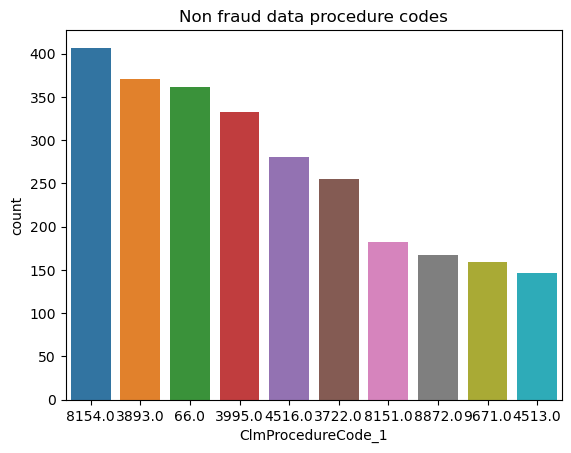

In [8]:
# subset datasets of fraud and non fraud
df_nofraud = df_full[df_full['Label']==0]
df_fraud = df_full[df_full['Label']==1]

# plot counts of top appearing procodure codes for non fraud data
sns.countplot(x='ClmProcedureCode_1', data=df_nofraud, order=df_nofraud['ClmProcedureCode_1'].value_counts().sort_values(ascending=False).index[1:11])

plt.title('Non fraud data procedure codes');

if save_figs:
    plt.savefig('figures/nonfraud_procedure_codes');

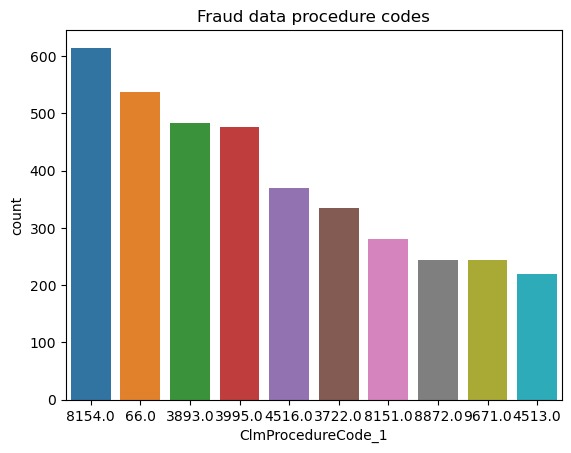

In [9]:
# plot counts of top appearing procedure codes for fraud data
sns.countplot(x='ClmProcedureCode_1', data=df_fraud, order=df_fraud['ClmProcedureCode_1'].value_counts().sort_values(ascending=False).index[1:11])
plt.title('Fraud data procedure codes');

if save_figs:
    plt.savefig('figures/fraud_procedure_codes');

In [17]:
# extract important claim codes, which are the unique codes found in the graphs above plus up to the 25th most common code
important_clm_codes = np.unique(np.append(df_nofraud['ClmProcedureCode_1'].value_counts().index[1:25], df_fraud['ClmProcedureCode_1'].value_counts().index[1:25]))
important_clm_codes

array([  66.,  309.,  387., 3491., 3722., 3772., 3812., 3893., 3950.,
       3995., 4513., 4516., 4523., 4525., 5123., 7935., 8108., 8151.,
       8152., 8154., 8622., 8872., 9339., 9390., 9671., 9672., 9921.])

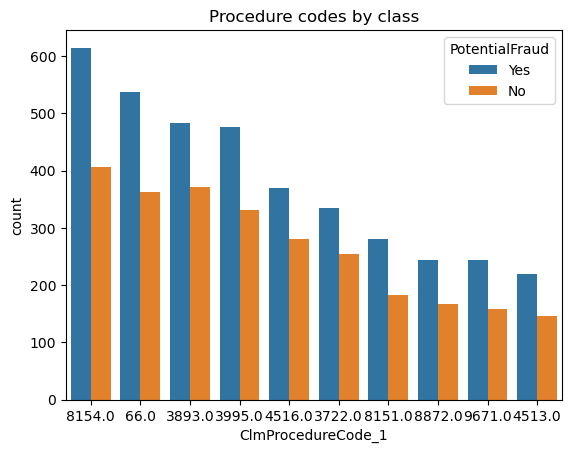

In [11]:
# plot counts of top appearing procedure codes with side by side bars for fraud vs non fraud
sns.countplot(x='ClmProcedureCode_1',hue='PotentialFraud',data=df_full, order=df_full['ClmProcedureCode_1'].value_counts().index[1:11]);
plt.title('Procedure codes by class');

if save_figs:
    plt.savefig('figures/class_procedure_codes');
# code 9904 - transfusion of packed cells
# code 4516 - EGD

In [98]:
# examine other providers who give the same procedure codes of 8154
out_8154 = df_full.loc[df_full['ClmProcedureCode_1'] == 8154.0]
out_8154['Provider'].value_counts()[:5]

PRV52019    16
PRV53808    10
PRV53706    10
PRV55462    10
PRV51146     8
Name: Provider, dtype: int64

In [99]:
# identify if most frequent providers under this code are fraudulent
print(df_label.loc[df_label['Provider']=='PRV52019'])
print(df_label.loc[df_label['Provider']=='PRV53808'])
print(df_label.loc[df_label['Provider']=='PRV53706'])

     Provider PotentialFraud
818  PRV52019            Yes
      Provider PotentialFraud
2258  PRV53808            Yes
      Provider PotentialFraud
2176  PRV53706            Yes


In [100]:
out_8154['Provider'].value_counts()[-5:]

PRV52687    1
PRV54566    1
PRV55912    1
PRV52459    1
PRV53159    1
Name: Provider, dtype: int64

In [101]:
# identify if least frequent providers under this code are fraudulent
print(df_label.loc[df_label['Provider']=='PRV55912'])
print(df_label.loc[df_label['Provider']=='PRV52459'])
print(df_label.loc[df_label['Provider']=='PRV53159'])

      Provider PotentialFraud
3928  PRV55912            Yes
      Provider PotentialFraud
1169  PRV52459             No
      Provider PotentialFraud
1731  PRV53159             No


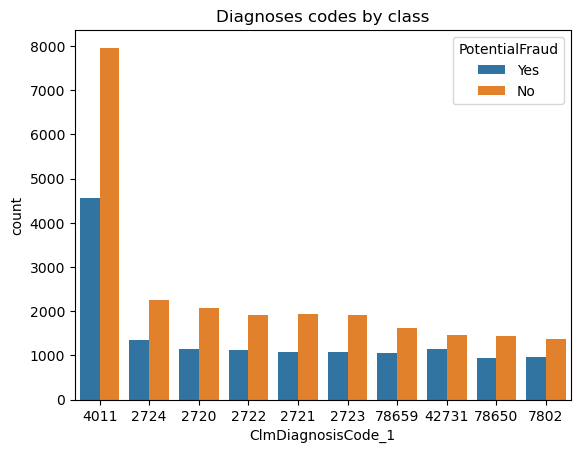

In [102]:
# plot counts of top appearing diagnoses codes with side by side bars for fraud vs non fraud
sns.countplot(x='ClmDiagnosisCode_1',hue='PotentialFraud',data=df_full, order=df_full['ClmDiagnosisCode_1'].value_counts().index[1:11]);
plt.title('Diagnoses codes by class');

if save_figs:
    plt.savefig('figures/class_diagnosis_codes');

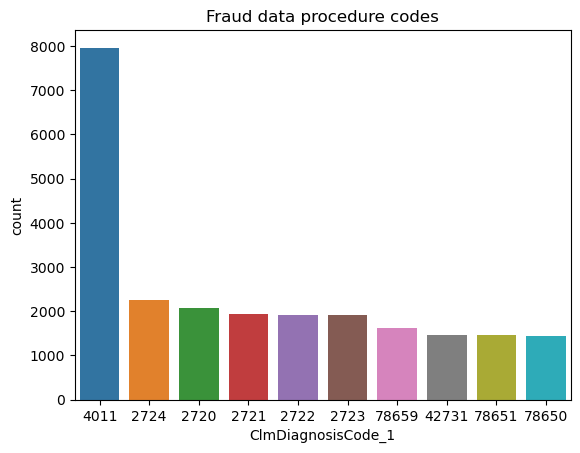

In [15]:
# plot counts of top appearing diagnoses codes for fraud data
sns.countplot(x='ClmDiagnosisCode_1', data=df_nofraud, order=df_nofraud['ClmDiagnosisCode_1'].value_counts().sort_values(ascending=False).index[1:11]);
plt.title('Fraud data procedure codes');

if save_figs:
    plt.savefig('figures/fraud_diagnosis_codes');

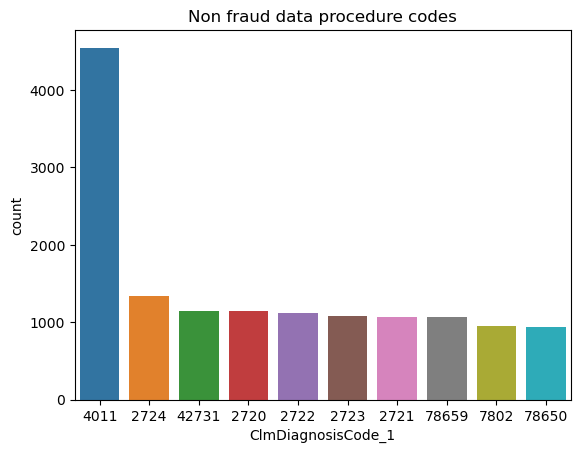

In [16]:
# plot counts of top appearing diagnoses codes for non fraud data
sns.countplot(x='ClmDiagnosisCode_1', data=df_fraud, order=df_fraud['ClmDiagnosisCode_1'].value_counts().sort_values(ascending=False).index[1:11]);
plt.title('Non fraud data procedure codes');

if save_figs:
    plt.savefig('figures/nonfraud_diagnosis_codes');

In [18]:
# extract important diagnoses codes, which are the unique codes found in the graphs above plus up to the 25th most common code
important_diag_codes = np.unique(np.append(df_nofraud['ClmDiagnosisCode_1'].value_counts().index[1:25], df_fraud['ClmDiagnosisCode_1'].value_counts().index[1:25]))
important_diag_codes

array(['185', '25000', '2720', '2721', '2722', '2723', '2724', '4011',
       '41401', '4271', '42731', '42732', '42761', '42769', '42781',
       '42789', '4279', '4280', '486', '49121', '5990', '7802', '78079',
       '7850', '78650', '78651', '78659', '79029', '7915', 'V4585',
       'V5789'], dtype=object)

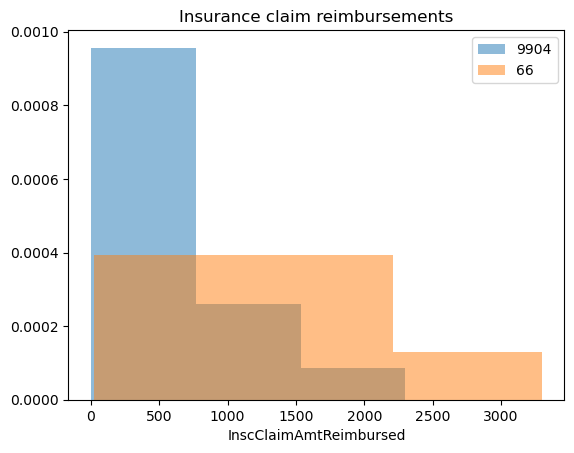

In [106]:
# examine insurance data for 9904 and 66 for outpatients
plt.hist(df_out[df_out['ClmProcedureCode_1']==9904]['InscClaimAmtReimbursed'], bins = 3, alpha=0.5, label='9904', density=True)
plt.hist(df_out[df_out['ClmProcedureCode_1']==66]['InscClaimAmtReimbursed'], bins = 3, alpha=0.5, label='66', density=True)
plt.legend();
plt.xlabel('InscClaimAmtReimbursed');
plt.title('Insurance claim reimbursements');

if save_figs:
    plt.savefig('figures/insurance_claims_by_provider');

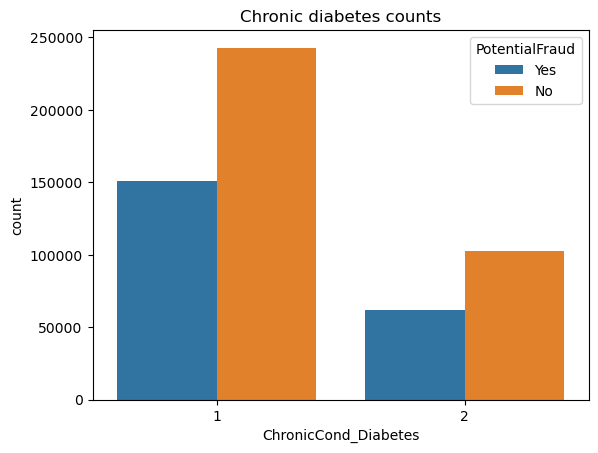

In [107]:
# examine differences in chronic diabetes indicators between classes
sns.countplot(x='ChronicCond_Diabetes',hue='PotentialFraud',data=df_full);
plt.title('Chronic diabetes counts');

if save_figs:
    plt.savefig('figures/chronic_diabetes_by_class');

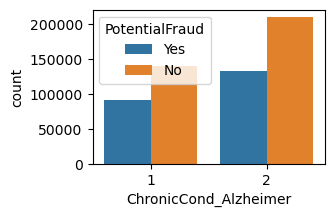

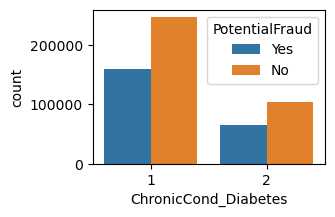

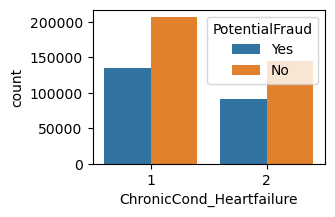

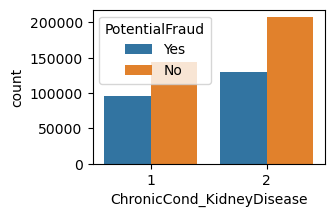

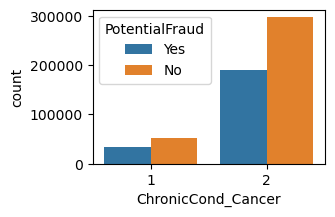

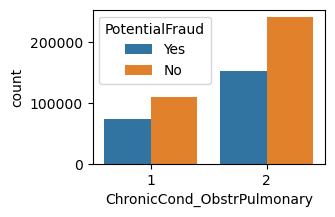

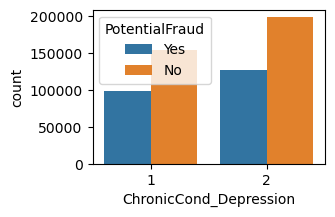

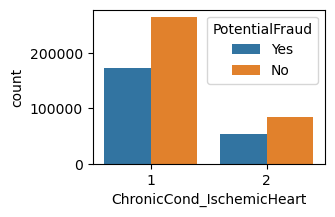

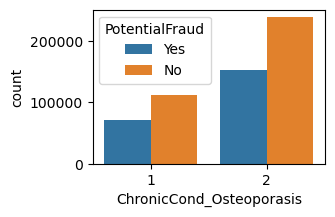

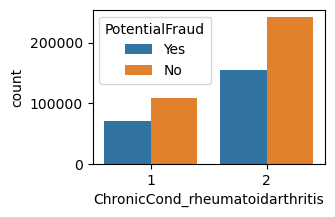

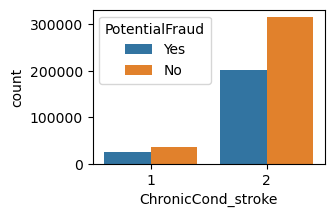

In [24]:
# repeat for other diseases
diseases = ['ChronicCond_Alzheimer', 'ChronicCond_Diabetes',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke']

for i in diseases:
    plt.figure(figsize=(3,2));
    sns.countplot(x=i,hue='PotentialFraud',data=df_full);
    plt.show();


# Preprocessing

In [19]:
# check which columns have null values
# diagnoses and procedure codes are indicators, so data points with no 7th code for example, are null in the 7th code column
df_full.isnull().sum()

BeneID                                  0
ClaimID                                 0
ClaimStartDt                            0
ClaimEndDt                              0
Provider                                0
InscClaimAmtReimbursed                  0
AttendingPhysician                   1508
OperatingPhysician                 443764
OtherPhysician                     358475
ClmDiagnosisCode_1                  10453
ClmDiagnosisCode_2                 195606
ClmDiagnosisCode_3                 315156
ClmDiagnosisCode_4                 393675
ClmDiagnosisCode_5                 446287
ClmDiagnosisCode_6                 473819
ClmDiagnosisCode_7                 492034
ClmDiagnosisCode_8                 504767
ClmDiagnosisCode_9                 516396
ClmDiagnosisCode_10                553201
ClmProcedureCode_1                 534901
ClmProcedureCode_2                 552721
ClmProcedureCode_3                 557242
ClmProcedureCode_4                 558093
ClmProcedureCode_5                

In [20]:
df_full['ChronicCond_ObstrPulmonary']

0        2
1        2
2        2
3        2
4        2
        ..
40469    2
40470    1
40471    1
40472    1
40473    2
Name: ChronicCond_ObstrPulmonary, Length: 558211, dtype: int64

In [21]:
# removed deceased patients 
df_full = df_full[pd.isnull(df_full['DOD'])]

In [22]:
# create new features 

# extract admissions and discharge dataes; extract dob and dod 
df_full['AdmissionDt'] = pd.to_datetime(df_full['AdmissionDt'])  
df_full['DischargeDt'] = pd.to_datetime(df_full['DischargeDt'])  
df_full['DOB'] = pd.to_datetime(df_full['DOB'])  
df_full['DOD'] = pd.to_datetime(df_full['DOD'])  

# compute stay duration = discharge - admission 
df_full['StayDuration'] = (df_full['DischargeDt'] - df_full['AdmissionDt']).dt.days
df_full['StayDuration'].fillna(0.0)

# compute age of patient
today = datetime(2023, 1, 1)
df_full['DOD'].fillna(today)
df_full['Age'] = ((today - df_full['DOB']).dt.days)/365

# one hot encode race variables
df_full = df_full.join(pd.get_dummies(df_full['Race'], drop_first=True))
df_full = df_full.rename(columns={2: "Race1", 3: "Race2", 5: "Race3"})

df_full = df_full.fillna(0)
df_full = df_full.drop_duplicates()

In [25]:
# replace 2s in chronic disease columns with 1s to make a binary indicator 
for i in diseases:
    df_full.loc[ df_full[i] == 2, i] = 0

In [26]:
# encode significant diagnoses and procedure codes extracted from earlier
for code in important_clm_codes: 
    df_full['Clm'+str(code)] = 0
    df_full.loc[df_full['ClmProcedureCode_1'].astype(float) == code, 'Clm'+str(code)] = 1

for code in important_diag_codes:
    df_full['Diag'+str(code)] = 0
    df_full.loc[df_full['ClmDiagnosisCode_1'] == code, 'Diag'+str(code)] = 1

In [27]:
# make the renal disease indicator binary 
df_full.loc[ df_full['RenalDiseaseIndicator'] == 'Y', 'RenalDiseaseIndicator'] = 1
df_full.loc[ df_full['RenalDiseaseIndicator'] == '0', 'RenalDiseaseIndicator'] = 0
df_full['RenalDiseaseIndicator'] = pd.to_numeric(df_full['RenalDiseaseIndicator'])


In [28]:
# make gender indicator binary 
df_full.loc[ df_full['Gender'] == 2, 'Gender'] = 0

# EDA on data grouped by provider

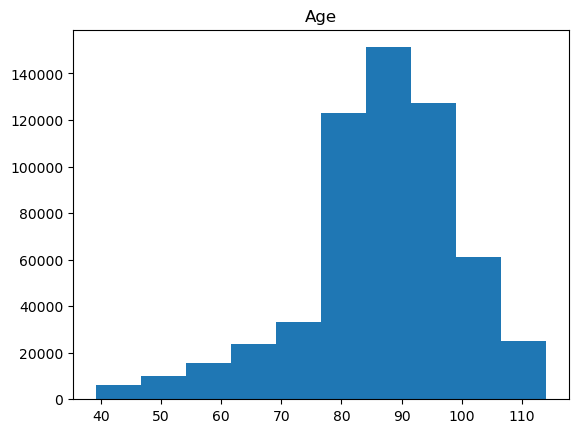

In [117]:
# plot age distribution
plt.hist(df_full['Age'], bins=10);
plt.title('Age');

if save_figs:
    plt.savefig('figures/age_dist');

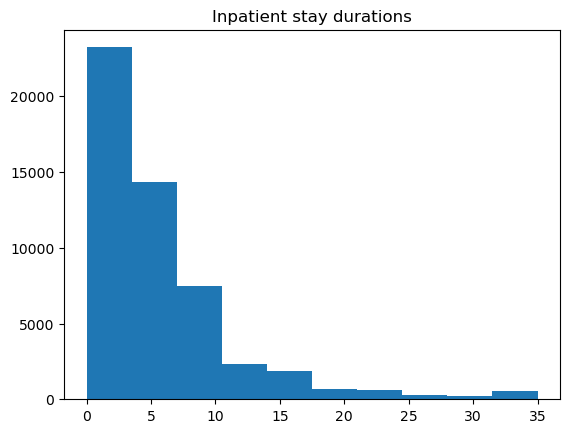

In [118]:
# plot the distribution of stay duration for inpatients 
plt.hist(df_full[df_full['Outpatient']==0]['StayDuration'], bins=10);
plt.title('Inpatient stay durations');

if save_figs:
    plt.savefig('figures/inpatient_stayduration');

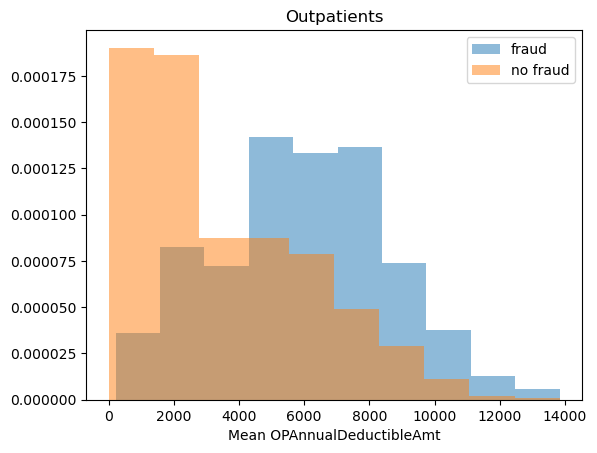

In [119]:
# determine differences between maximum annual deductible amounts per provider for outpatients
out_data = df_full[df_full['Outpatient']==1]
in_data = df_full[df_full['Outpatient']==0]

plt.hist(df_fraud.groupby('Provider').agg('max', numeric_only=True)['OPAnnualDeductibleAmt'], density=True, bins=10, label='fraud', alpha=0.5);
plt.hist(df_nofraud.groupby('Provider').agg('max', numeric_only=True)['OPAnnualDeductibleAmt'], density=True, bins=10, label='no fraud', alpha=0.5);
plt.legend();
plt.xlabel('Mean OPAnnualDeductibleAmt');
plt.title('Outpatients');

if save_figs:
    plt.savefig('figures/class_outpatient_deductibles');

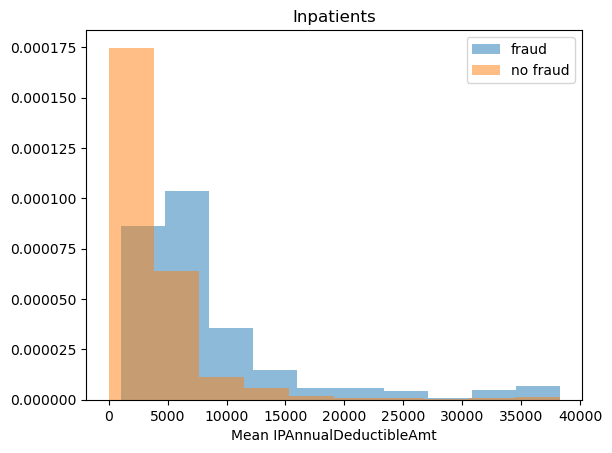

In [120]:
# determine differences between maximum annual deductible amounts per provider for inpatients
plt.hist(df_fraud.groupby('Provider').agg('max', numeric_only=True)['IPAnnualDeductibleAmt'], density=True, bins=10, label='fraud', alpha=0.5);
plt.hist(df_nofraud.groupby('Provider').agg('max', numeric_only=True)['IPAnnualDeductibleAmt'], density=True, bins=10, label='no fraud',  alpha=0.5);
plt.legend();
plt.xlabel('Mean IPAnnualDeductibleAmt');
plt.title('Inpatients');

if save_figs:
    plt.savefig('figures/class_inpatient_deductibles');

# Models

In [29]:
df_full.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1',
       ...
       'Diag7802', 'Diag78079', 'Diag7850', 'Diag78650', 'Diag78651',
       'Diag78659', 'Diag79029', 'Diag7915', 'DiagV4585', 'DiagV5789'],
      dtype='object', length=120)

In [30]:
df_full.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,Diag7802,Diag78079,Diag7850,Diag78650,Diag78651,Diag78659,Diag79029,Diag7915,DiagV4585,DiagV5789
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,0,0,78943,...,0,0,0,0,0,0,0,0,0,0
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,0,0,1970,...,0,0,0,0,0,0,0,0,0,0
1,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,0,0,71988,...,0,0,0,0,0,0,0,0,0,0
1,BENE17521,CLM34721,2009-01-20,2009-02-01,PRV55912,19000,PHY349293,PHY370861,PHY363291,4240,...,0,0,0,0,0,0,0,0,0,0
2,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,0,0,82382,...,0,0,0,0,0,0,0,0,0,0


In [31]:
# save processed data as csv
df_full.to_csv('data/df_full.csv')

In [2]:
df_full = pd.read_csv('data/df_full.csv')

/tmp/ipykernel_354/1217368759.py:1: DtypeWarning: Columns (56,57,58) have mixed types. Specify dtype option on import or set low_memory=False.
  df_full = pd.read_csv('data/df_full.csv')


In [32]:
df_full.columns[50:]

Index(['OPAnnualDeductibleAmt', 'PotentialFraud', 'Label', 'Outpatient',
       'AdmissionDt', 'DischargeDt', 'DiagnosisGroupCode', 'StayDuration',
       'Age', 'Race1', 'Race2', 'Race3', 'Clm66.0', 'Clm309.0', 'Clm387.0',
       'Clm3491.0', 'Clm3722.0', 'Clm3772.0', 'Clm3812.0', 'Clm3893.0',
       'Clm3950.0', 'Clm3995.0', 'Clm4513.0', 'Clm4516.0', 'Clm4523.0',
       'Clm4525.0', 'Clm5123.0', 'Clm7935.0', 'Clm8108.0', 'Clm8151.0',
       'Clm8152.0', 'Clm8154.0', 'Clm8622.0', 'Clm8872.0', 'Clm9339.0',
       'Clm9390.0', 'Clm9671.0', 'Clm9672.0', 'Clm9921.0', 'Diag185',
       'Diag25000', 'Diag2720', 'Diag2721', 'Diag2722', 'Diag2723', 'Diag2724',
       'Diag4011', 'Diag41401', 'Diag4271', 'Diag42731', 'Diag42732',
       'Diag42761', 'Diag42769', 'Diag42781', 'Diag42789', 'Diag4279',
       'Diag4280', 'Diag486', 'Diag49121', 'Diag5990', 'Diag7802', 'Diag78079',
       'Diag7850', 'Diag78650', 'Diag78651', 'Diag78659', 'Diag79029',
       'Diag7915', 'DiagV4585', 'DiagV5789'],


In [34]:
# extracts needed columns  
columns = ['InscClaimAmtReimbursed','Gender', 'Race',
       'RenalDiseaseIndicator', 'NoOfMonths_PartACov',
       'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke',
       'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt',
       'Outpatient', 'StayDuration', 'Age', 'Race1', 'Race2', 'Race3',
           'Clm66.0', 'Clm309.0', 'Clm387.0',
       'Clm3491.0', 'Clm3722.0', 'Clm3772.0', 'Clm3812.0', 'Clm3893.0',
       'Clm3950.0', 'Clm3995.0', 'Clm4513.0', 'Clm4516.0', 'Clm4523.0',
       'Clm4525.0', 'Clm5123.0', 'Clm7935.0', 'Clm8108.0', 'Clm8151.0',
       'Clm8152.0', 'Clm8154.0', 'Clm8622.0', 'Clm8872.0', 'Clm9339.0',
       'Clm9390.0', 'Clm9671.0', 'Clm9672.0', 'Clm9921.0', 'Diag185',
       'Diag25000', 'Diag2720', 'Diag2721', 'Diag2722', 'Diag2723', 'Diag2724',
       'Diag4011', 'Diag41401', 'Diag4271', 'Diag42731', 'Diag42732',
       'Diag42761', 'Diag42769', 'Diag42781', 'Diag42789', 'Diag4279',
       'Diag4280', 'Diag486', 'Diag49121', 'Diag5990', 'Diag7802', 'Diag78079',
       'Diag7850', 'Diag78650', 'Diag78651', 'Diag78659', 'Diag79029',
       'Diag7915', 'DiagV4585', 'DiagV5789']


In [35]:
# get X and y matrices
X = df_full[columns]
y = df_full['Label']

In [36]:
X.head()

,InscClaimAmtReimbursed,Gender,Race,RenalDiseaseIndicator,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,...,Diag7802,Diag78079,Diag7850,Diag78650,Diag78651,Diag78659,Diag79029,Diag7915,DiagV4585,DiagV5789
0,30,0,1,0,12,12,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,26000,1,1,0,12,12,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,40,1,1,0,12,12,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,19000,0,1,0,12,12,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,200,1,1,0,12,12,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Understand features in X matrix with visualizations

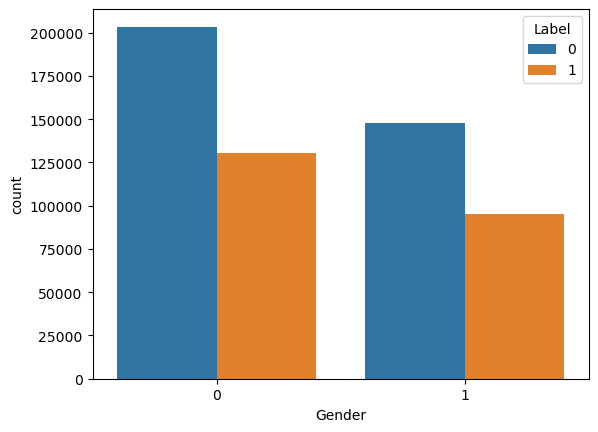

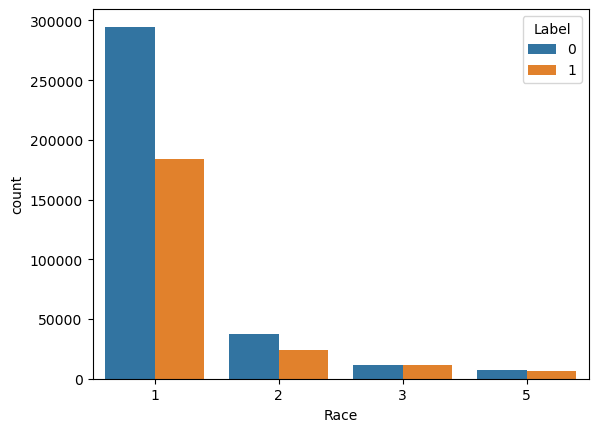

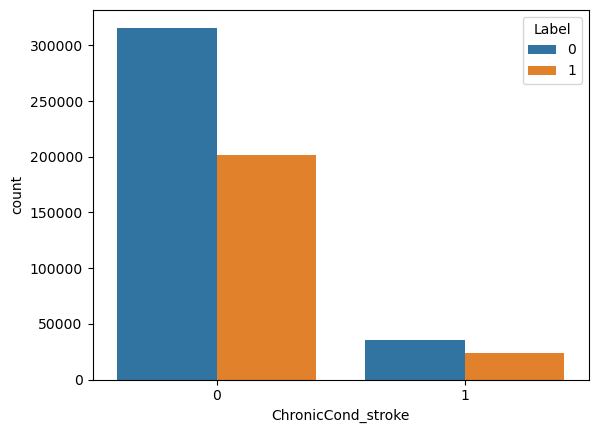

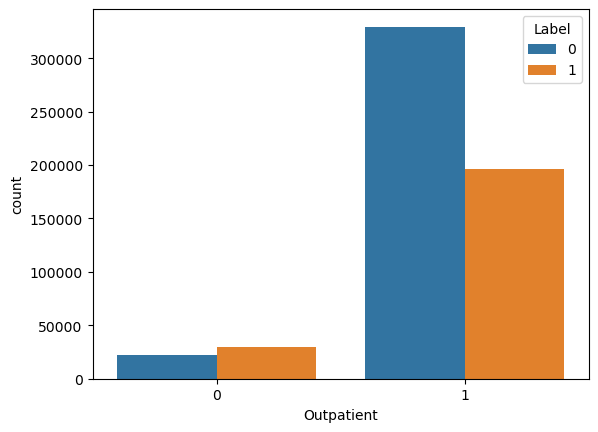

In [37]:
sns.countplot(x='Gender', hue='Label', data=df_full);
plt.show()
sns.countplot(x='Race', hue='Label', data=df_full);
plt.show()
sns.countplot(x='ChronicCond_stroke', hue='Label', data=df_full);
plt.show()
sns.countplot(x='Outpatient', hue='Label', data=df_full);

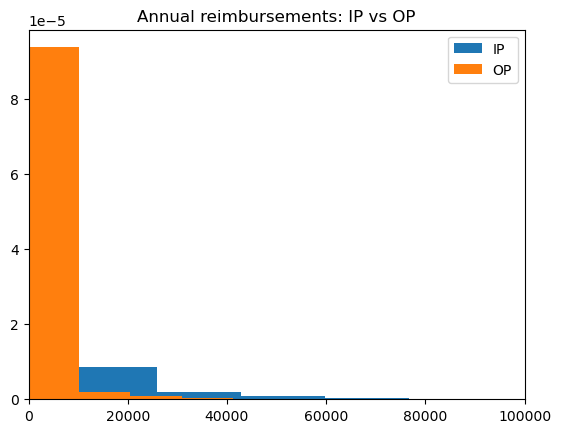

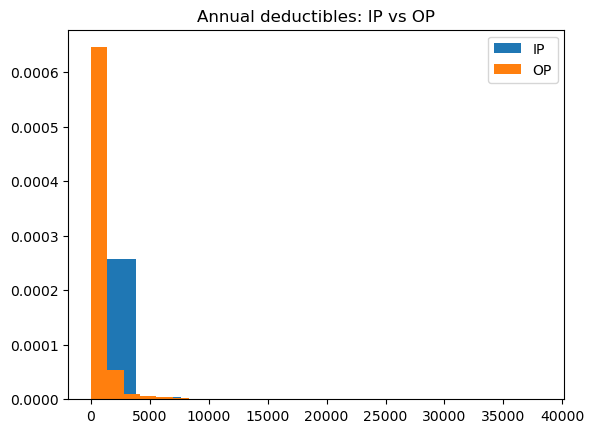

In [79]:
plt.hist(df_full['IPAnnualReimbursementAmt'], label='IP', density=True);
plt.hist(df_full['OPAnnualReimbursementAmt'], label='OP', density=True);
plt.title('Annual reimbursements: IP vs OP');
plt.xlim([0,100000]);
plt.legend();
plt.show();
plt.hist(df_full['IPAnnualDeductibleAmt'], label='IP', density=True);
plt.hist(df_full['OPAnnualDeductibleAmt'], label='OP', density=True);
plt.title('Annual deductibles: IP vs OP');
plt.legend();


### Simple models

In [39]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# run logistic regression model 
logreg = LogisticRegression(random_state=0).fit(X_train, y_train)
logreg_preds = logreg.predict(X_train)

logreg.score(X_train, y_train)

0.6131554368889337

In [40]:
precision_recall_fscore_support(y_train, logreg_preds, average='macro')

(0.5936218945455267, 0.5126865128373025, 0.42218438115869156, None)

In [41]:
# run XGB model
xgb = XGBClassifier().fit(X_train, y_train)
xgb_preds = xgb.predict(X_train)
accuracy = accuracy_score(y_train, xgb_preds)

print(accuracy)
precision_recall_fscore_support(y_train, xgb_preds, average='macro')

0.6487347257688536


(0.6627615873050096, 0.5678350082279566, 0.533818496805533, None)

In [42]:
xgb.feature_importances_

array([0.00273985, 0.00484382, 0.0246893 , 0.00457604, 0.00631331,
       0.00617209, 0.00498402, 0.00472674, 0.0062598 , 0.00597237,
       0.00478879, 0.00474273, 0.00641266, 0.0059217 , 0.00582928,
       0.00516465, 0.00623976, 0.00657436, 0.00602989, 0.00717005,
       0.0072775 , 0.4988981 , 0.00485107, 0.00697066, 0.00586471,
       0.03229538, 0.08966862, 0.00379217, 0.00102116, 0.        ,
       0.        , 0.00699167, 0.0043095 , 0.00069818, 0.00436255,
       0.00497486, 0.00309151, 0.00449565, 0.00388524, 0.00148599,
       0.00576007, 0.00206129, 0.00553437, 0.        , 0.00618839,
       0.0049123 , 0.00387724, 0.00645283, 0.        , 0.00305303,
       0.00467527, 0.00295034, 0.00363814, 0.00477393, 0.00262675,
       0.00347222, 0.00494084, 0.00466176, 0.00536118, 0.00328775,
       0.0065069 , 0.00384326, 0.00369705, 0.00379504, 0.00580354,
       0.00499001, 0.00500866, 0.        , 0.00413588, 0.00197247,
       0.00954876, 0.0060018 , 0.00550255, 0.0077361 , 0.00618

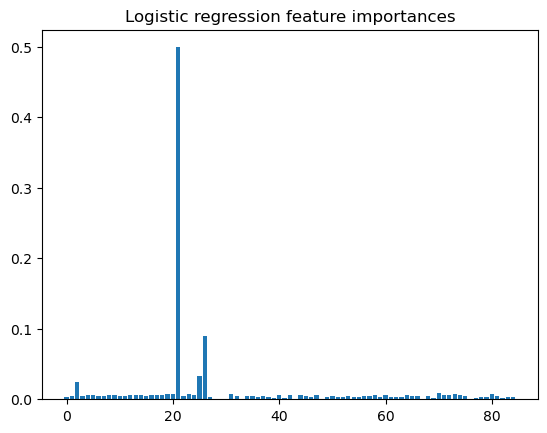

<Figure size 640x480 with 0 Axes>

In [43]:
# plot feature importances
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_);
plt.title('Logistic regression feature importances');
plt.show();

if save_figs:
    plt.savefig('figures/lr_features');

In [44]:
# find most important feature
columns[np.argmax(xgb.feature_importances_)]

'Outpatient'

### Model separately on outpatient and inpatients

In [45]:
# run XGB model on only outpatient data
outpatient_data = df_full[df_full['Outpatient']==1]

outpatient_X = outpatient_data[columns]
outpatient_y = outpatient_data['Label']
X_train, X_test, y_train, y_test = train_test_split(outpatient_X, outpatient_y, test_size=0.33, random_state=42)

In [46]:
# XGB 
xgb = XGBClassifier().fit(X_train, y_train)
xgb_preds = xgb.predict(X_train)
accuracy = accuracy_score(y_train, xgb_preds)

print(accuracy)
precision_recall_fscore_support(y_train, xgb_preds, average='macro')

0.6557244773006867


(0.7205588104062399, 0.5441980867227934, 0.48337960889831433, None)

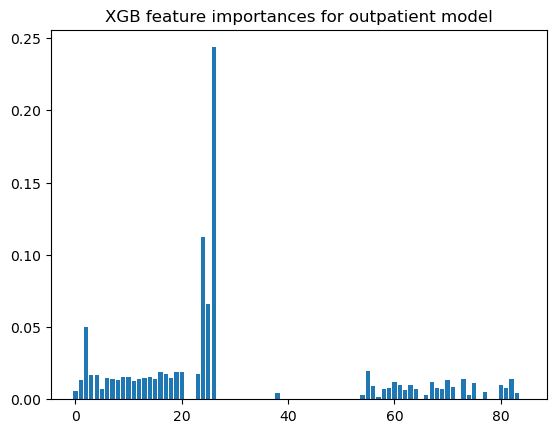

<Figure size 640x480 with 0 Axes>

In [47]:
# plot feature importances
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.title('XGB feature importances for outpatient model');
plt.show();

if save_figs:
    plt.savefig('figures/xgb_outpatient_features');

In [48]:
# find most important feature
columns[np.argmax(xgb.feature_importances_)]

'Race3'

In [49]:
# run XGB model on only inpatient data
inpatient_data = df_full[df_full['Outpatient']==0]

inpatient_X = inpatient_data[columns]
inpatient_y = inpatient_data['Label']
X_train, X_test, y_train, y_test = train_test_split(inpatient_X, inpatient_y, test_size=0.33, random_state=42)

In [50]:
# XGB 
xgb = XGBClassifier().fit(X_train, y_train)
xgb_preds = xgb.predict(X_train)
accuracy = accuracy_score(y_train, xgb_preds)

print(accuracy)
precision_recall_fscore_support(y_train, xgb_preds, average='macro')

0.7445145602964164


(0.7771529647060764, 0.7111576070227326, 0.7136605390073174, None)

In [51]:
accuracy_score(y_test, xgb.predict(X_test))


0.6143629525152797

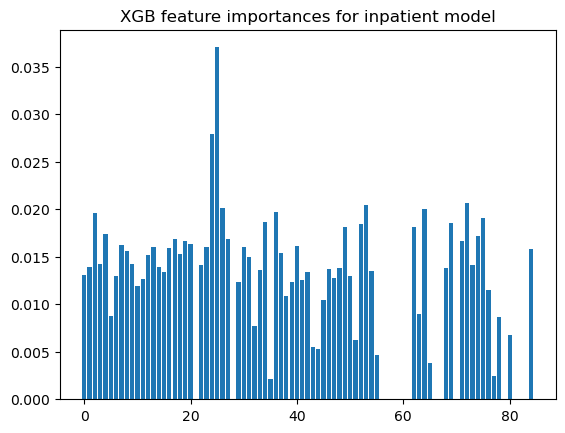

<Figure size 640x480 with 0 Axes>

In [52]:
# plot feature importances
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.title('XGB feature importances for inpatient model');
plt.show();

if save_figs:
    plt.savefig('figures/xgb_inpatient_features');

In [53]:
# find most important feature
columns[np.argmax(xgb.feature_importances_)]

'Race2'

In [22]:
# are there more instances of the same provider assigning code 5123 among fraudulent providers?
inpatient_data[(inpatient_data['Clm5123.0']==1) & (inpatient_data['Label']==1)]['Provider'].value_counts().values

array([7, 6, 5, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1])

In [20]:
# are there less instances of the same provider assigning code 5123 among non fraudulent providers?
inpatient_data[(inpatient_data['Clm5123.0']==1) & (inpatient_data['Label']==0)]['Provider'].value_counts().values

array([4, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### Grouping by provider to make new features

In [54]:
# group by provider and aggregate for variables 
inpatient_data['clmIDcount_p'] = inpatient_data.groupby('Provider')['ClaimID'].transform('count')
inpatient_data['attendcount_p'] = inpatient_data.groupby(['Provider', 'AttendingPhysician'])['ClaimID'].transform('count')
inpatient_data['operatingcount_p'] = inpatient_data.groupby(['Provider', 'OperatingPhysician'])['ClaimID'].transform('count')
inpatient_data['otherphys_p'] = inpatient_data.groupby(['Provider', 'OtherPhysician'])['ClaimID'].transform('count')
inpatient_data['deduc_p'] = inpatient_data.groupby('Provider')['IPAnnualDeductibleAmt'].transform('mean')
inpatient_data['clm1_p'] = inpatient_data.groupby(['Provider', 'ClmProcedureCode_1'])['ClaimID'].transform('count')
inpatient_data['clm2_p'] = inpatient_data.groupby(['Provider', 'ClmProcedureCode_2'])['ClaimID'].transform('count')
inpatient_data['diag1_p'] = inpatient_data.groupby(['Provider', 'ClmDiagnosisCode_1'])['ClaimID'].transform('count')
inpatient_data['diag2_p'] = inpatient_data.groupby(['Provider', 'ClmDiagnosisCode_2'])['ClaimID'].transform('count')
inpatient_data['staydur_p'] = inpatient_data.groupby('Provider')['StayDuration'].transform('mean')
inpatient_data['race1_p'] = inpatient_data.groupby('Provider')['Race1'].transform('sum')
inpatient_data['race2_p'] = inpatient_data.groupby('Provider')['Race2'].transform('sum')
inpatient_data['race3_p'] = inpatient_data.groupby('Provider')['Race3'].transform('sum')

### Visualize new grouped features

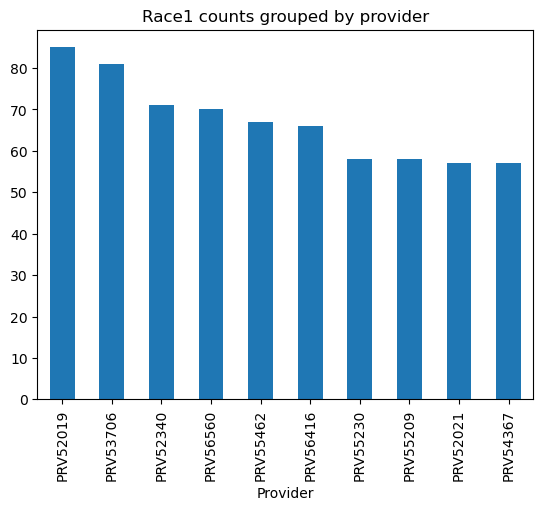

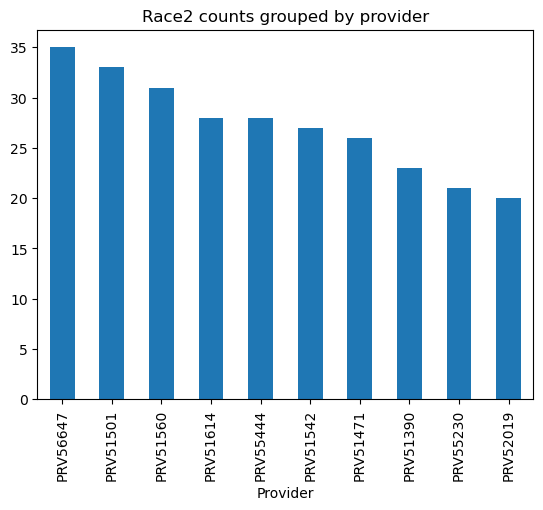

In [55]:
# visualize grouped race data
inpatient_data.groupby('Provider')['Race1'].agg('sum').sort_values(ascending=False)[:10].plot(kind='bar')
plt.title('Race1 counts grouped by provider');
plt.show()
inpatient_data.groupby('Provider')['Race2'].agg('sum').sort_values(ascending=False)[:10].plot(kind='bar')
plt.title('Race2 counts grouped by provider');
plt.show()

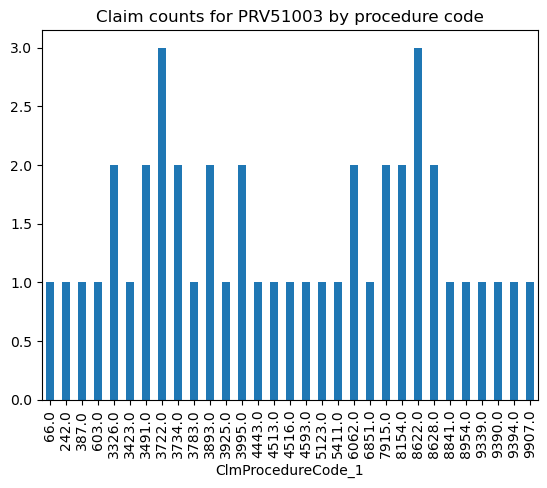

In [56]:
# visualize claim counts per provider per claim procedure code
inpatient_data.groupby(['Provider', 'ClmProcedureCode_1'])['ClaimID'].agg('count')['PRV51003'].iloc[1:].plot(kind='bar')
plt.title('Claim counts for PRV51003 by procedure code');

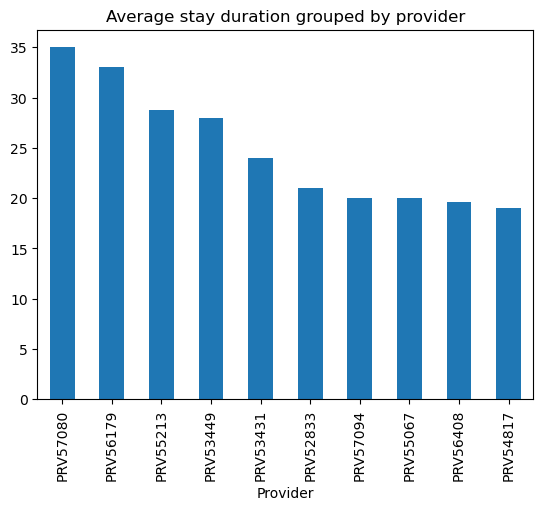

In [57]:
inpatient_data.groupby('Provider')['StayDuration'].agg('mean').sort_values(ascending=False)[:10].plot(kind='bar');
plt.title('Average stay duration grouped by provider');

### Run models with grouped features

In [59]:
grouped_columns = ['InscClaimAmtReimbursed','Gender', 'Race',
       'RenalDiseaseIndicator', 'NoOfMonths_PartACov',
       'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke',
       'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt',
       'Outpatient', 'StayDuration', 'Age', 'Race1', 'Race2', 'Race3',
       'Clm66.0', 'Clm309.0', 'Clm387.0',
       'Clm3491.0', 'Clm3722.0', 'Clm3772.0', 'Clm3812.0', 'Clm3893.0',
       'Clm3950.0', 'Clm3995.0', 'Clm4513.0', 'Clm4516.0', 'Clm4523.0',
       'Clm4525.0', 'Clm5123.0', 'Clm7935.0', 'Clm8108.0', 'Clm8151.0',
       'Clm8152.0', 'Clm8154.0', 'Clm8622.0', 'Clm8872.0', 'Clm9339.0',
       'Clm9390.0', 'Clm9671.0', 'Clm9672.0', 'Clm9921.0', 'Diag185',
       'Diag25000', 'Diag2720', 'Diag2721', 'Diag2722', 'Diag2723', 'Diag2724',
       'Diag4011', 'Diag41401', 'Diag4271', 'Diag42731', 'Diag42732',
       'Diag42761', 'Diag42769', 'Diag42781', 'Diag42789', 'Diag4279',
       'Diag4280', 'Diag486', 'Diag49121', 'Diag5990', 'Diag7802', 'Diag78079',
       'Diag7850', 'Diag78650', 'Diag78651', 'Diag78659', 'Diag79029',
       'Diag7915', 'DiagV4585', 'DiagV5789', 'clmIDcount_p', 'attendcount_p', 'operatingcount_p',
       'otherphys_p', 'deduc_p', 'clm1_p', 'clm2_p', 'diag1_p',
       'diag2_p', 'staydur_p', 'race1_p', 'race2_p', 'race3_p']

In [60]:
# logistic regression 
inpatient_X = inpatient_data[grouped_columns]
inpatient_y = inpatient_data['Label']
X_train, X_test, y_train, y_test = train_test_split(inpatient_X, inpatient_y, test_size=0.33, random_state=42)

# run logistic regression model 
logreg = LogisticRegression(random_state=0).fit(X_train, y_train)
logreg_preds = logreg.predict(X_train)

logreg.score(X_train, y_train)

/srv/conda/envs/notebook/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7768193133792625

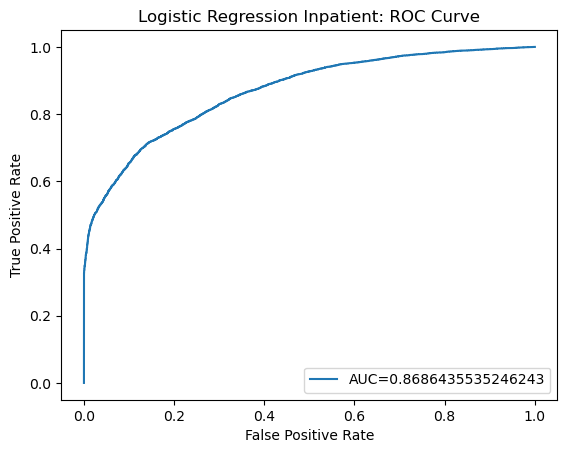

In [61]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Logistic Regression Inpatient: ROC Curve');
plt.legend(loc=4)
plt.show()

In [62]:
# XGB 
xgb = XGBClassifier(max_depth = 2).fit(X_train, y_train)
xgb_preds = xgb.predict(X_train)
accuracy = accuracy_score(y_train, xgb_preds)

print(accuracy)
precision_recall_fscore_support(y_train, xgb_preds, average='macro')

0.9091645921380189


(0.906716007383984, 0.9154824909958389, 0.9083116320887137, None)

In [63]:
# testing accuracy
accuracy = accuracy_score(y_test, xgb.predict(X_test))
accuracy

0.9073812881993418

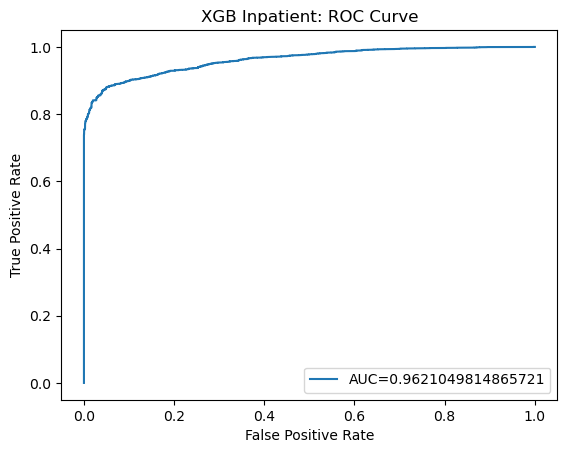

In [64]:
y_pred_proba = xgb.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('XGB Inpatient: ROC Curve');
plt.legend(loc=4)
plt.show()

In [65]:
# group by provider and aggregate for variables 
outpatient_data['clmIDcount_p'] = outpatient_data.groupby('Provider')['ClaimID'].transform('count')
outpatient_data['attendcount_p'] = outpatient_data.groupby(['Provider', 'AttendingPhysician'])['ClaimID'].transform('count')
outpatient_data['operatingcount_p'] = outpatient_data.groupby(['Provider', 'OperatingPhysician'])['ClaimID'].transform('count')
outpatient_data['otherphys_p'] = outpatient_data.groupby(['Provider', 'OtherPhysician'])['ClaimID'].transform('count')
outpatient_data['deduc_p'] = outpatient_data.groupby('Provider')['IPAnnualDeductibleAmt'].transform('mean')
outpatient_data['clm1_p'] = outpatient_data.groupby(['Provider', 'ClmProcedureCode_1'])['ClaimID'].transform('count')
outpatient_data['clm2_p'] = outpatient_data.groupby(['Provider', 'ClmProcedureCode_2'])['ClaimID'].transform('count')
outpatient_data['diag1_p'] = outpatient_data.groupby(['Provider', 'ClmDiagnosisCode_1'])['ClaimID'].transform('count')
outpatient_data['diag2_p'] = outpatient_data.groupby(['Provider', 'ClmDiagnosisCode_2'])['ClaimID'].transform('count')
outpatient_data['staydur_p'] = outpatient_data.groupby('Provider')['StayDuration'].transform('mean')
outpatient_data['race1_p'] = outpatient_data.groupby('Provider')['Race1'].transform('sum')
outpatient_data['race2_p'] = outpatient_data.groupby('Provider')['Race2'].transform('sum')
outpatient_data['race3_p'] = outpatient_data.groupby('Provider')['Race3'].transform('sum')

In [66]:
# logistic regression
outpatient_X = outpatient_data[grouped_columns]
outpatient_y = outpatient_data['Label']
X_train, X_test, y_train, y_test = train_test_split(outpatient_X, outpatient_y, test_size=0.33, random_state=42)

# run logistic regression model 
logreg = LogisticRegression(random_state=0).fit(X_train, y_train)
logreg_preds = logreg.predict(X_train)

logreg.score(X_train, y_train)

/srv/conda/envs/notebook/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8249713754826392

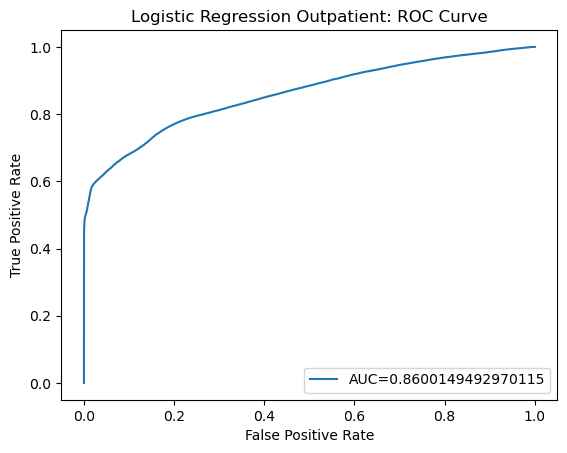

In [67]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Logistic Regression Outpatient: ROC Curve');
plt.legend(loc=4)
plt.show()

In [68]:
# XGB 
xgb = XGBClassifier(max_depth=2).fit(X_train, y_train)
xgb_preds = xgb.predict(X_train)
accuracy = accuracy_score(y_train, xgb_preds)

print(accuracy)
precision_recall_fscore_support(y_train, xgb_preds, average='macro')

0.9107085526932617


(0.9363236880859458, 0.8809369482138333, 0.8989694485354591, None)

In [69]:
# testing accuracy
accuracy = accuracy_score(y_test, xgb.predict(X_test))
accuracy

0.9106132361169597

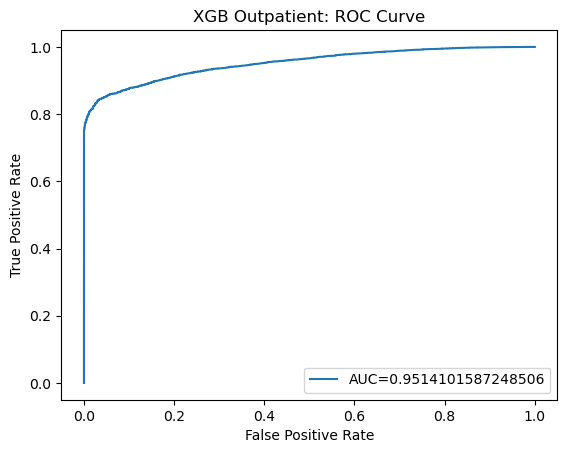

In [70]:
y_pred_proba = xgb.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('XGB Outpatient: ROC Curve');
plt.legend(loc=4)
plt.show()

### Apply new features to original data (not separated by inpatient and oupatient)


In [71]:
# group by provider and aggregate for variables 
df_full['clmIDcount_p'] = df_full.groupby('Provider')['ClaimID'].transform('count')
df_full['attendcount_p'] = df_full.groupby(['Provider', 'AttendingPhysician'])['ClaimID'].transform('count')
df_full['operatingcount_p'] = df_full.groupby(['Provider', 'OperatingPhysician'])['ClaimID'].transform('count')
df_full['otherphys_p'] = df_full.groupby(['Provider', 'OtherPhysician'])['ClaimID'].transform('count')
df_full['deduc_p'] = df_full.groupby('Provider')['IPAnnualDeductibleAmt'].transform('mean')
df_full['clm1_p'] = df_full.groupby(['Provider', 'ClmProcedureCode_1'])['ClaimID'].transform('count')
df_full['clm2_p'] = df_full.groupby(['Provider', 'ClmProcedureCode_2'])['ClaimID'].transform('count')
df_full['diag1_p'] = df_full.groupby(['Provider', 'ClmDiagnosisCode_1'])['ClaimID'].transform('count')
df_full['diag2_p'] = df_full.groupby(['Provider', 'ClmDiagnosisCode_2'])['ClaimID'].transform('count')
df_full['staydur_p'] = df_full.groupby('Provider')['StayDuration'].transform('mean')
df_full['race1_p'] = df_full.groupby('Provider')['Race1'].transform('sum')
df_full['race2_p'] = df_full.groupby('Provider')['Race2'].transform('sum')
df_full['race3_p'] = df_full.groupby('Provider')['Race3'].transform('sum')

In [72]:
X = df_full[grouped_columns]
y = df_full['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# XGB 
xgb = XGBClassifier(max_depth=2).fit(X_train, y_train)
xgb_preds = xgb.predict(X_train)
accuracy = accuracy_score(y_train, xgb_preds)

print(accuracy)
precision_recall_fscore_support(y_train, xgb_preds, average='macro')

0.9408693537412326


(0.9436836429507549, 0.9321430803861003, 0.9371849158833272, None)

In [73]:
# testing accuracy
accuracy = accuracy_score(y_test, xgb.predict(X_test))
accuracy

0.9398397898883782

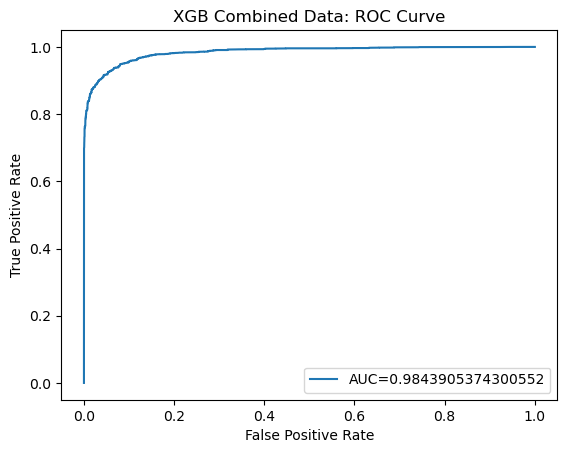

In [74]:
y_pred_proba = xgb.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('XGB Combined Data: ROC Curve');
plt.legend(loc=4)
plt.show()